In [1]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import sys
from stareg.star_model import StarModel
from stareg.smooth import Smooths as s
from stareg.smooth import TensorProductSmooths as tps
from stareg.utils import check_constraint, check_constraint_full_model
from stareg.utils import test_model_against_constraints

from scipy.linalg import block_diag
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_X_y
from sklearn.model_selection import train_test_split
from numpy.linalg import lstsq

In [2]:
np.random.seed(42)
n_samples = 10000
X = np.random.uniform(size=2*n_samples).reshape(n_samples, 2)

X.sort(axis=0)
#y = np.sin(X[:,0])**2 * np.cos(X[:,1])
X = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
     
y = -1*X[:,0]**2 + np.exp(X[:,1]) + X[:,0]*X[:,1]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.9)

m2 = ( ('s(1)', 'dec', 25, (2, 1), "quantile"),  
      ('s(2)', 'inc', 25, (0.1, 1), "quantile"), 
      ('t(1,2)', 'inc', (5, 5), (0.23, 1), "equidistant"), )
m3 = ( ('s(1)', 'dec', 25, (2, 1001), "quantile"),  
      ('s(2)', 'inc', 25, (0.1, 1001), "quantile"), 
      ('t(1,2)', 'inc', (5, 5), (0.23, 1), "equidistant"), )


In [3]:
M2 = StarModel(description=m2)
M3 = StarModel(description=m3)

In [4]:
M2.fit(X=Xtrain, y=ytrain, plot_=0)
M3.fit(X=Xtrain, y=ytrain, plot_=0)

# Mbest = M__.calc_GCV(X=Xtrain, y=ytrain, n_grid=2)

StarModel(s(1)={'constraint': 'dec', 'knot_type': 'quantile',
                'lam': {'constraint': 1001, 'smoothness': 2}, 'n_param': 25},
          s(2)={'constraint': 'inc', 'knot_type': 'quantile',
                'lam': {'constraint': 1001, 'smoothness': 0.1}, 'n_param': 25},
          t(1,2)={'constraint': 'inc', 'knot_type': 'equidistant',
                  'lam': {'constraint': 1, 'smoothness': 0.23},
                  'n_param': (5, 5)})

In [8]:
M2.predict(X=Xtest)

(1000,)

In [9]:
M2.eval_metric(X=Xtest, y=ytest)

0.52084

In [10]:
M3.eval_metric(X=Xtest, y=ytest)


0.51887

In [11]:
test_model_against_constraints(M2)

0.5208356484053783

In [12]:
test_model_against_constraints(M3)

0.5188724673111828

In [14]:
from stareg.utils import test_against_constraint

In [18]:
t = test_against_constraint(constraint="inc", y_pred=ytest)

In [21]:
M2.eval_metric(X=Xtest, y=ytest)

0.33334

In [16]:
M2.MSPE(X=Xtest, y=ytest, precision=9)

1.974e-06

In [17]:
Mbest.MSPE(X=Xtest, y=ytest, precision=9)

4e-09

In [37]:
ypred = M2.predict(X=Xtest)

In [38]:
ybest_pred = Mbest.predict(X=Xtest)

In [44]:
mean_squared_error(ypred, ytest).round(8)

1.05e-05

In [40]:
mean_squared_error(ybest_pred, ytest)

1.318834617048248e-08

In [19]:
Mbest.mse

0.0

In [5]:
ypred = M2.predict(X=Xtest)
mean_squared_error(ypred, ytest)

1.0501036940188835e-05

In [6]:
M2.predict_single_point(X=Xtest[0,:])

4.512630097427278

In [7]:
M2.confidence_interval(X=X)

(array([-3.13514118e+13, -1.10868685e+13, -2.98619565e+13, -5.39120986e+12,
        -2.78925804e+13, -3.61193773e+13, -1.50473489e+13, -7.48411167e+12,
        -2.63446536e+13, -2.20556651e+13, -3.05072875e+13, -3.29445255e+13,
        -3.04048565e+13, -9.61536621e+12, -1.85189293e+13, -1.37763096e+13,
        -3.55715131e+13, -3.39228336e+13, -1.28398134e+13, -1.19932633e+13,
        -1.48089058e+13, -3.04120357e+13, -2.10335821e+13, -1.78640258e+13,
        -4.55402930e+12, -1.97388115e+13, -1.06068908e+13, -3.47964439e+13,
        -3.13949180e+13, -1.74101923e+13, -2.77211037e+12, -1.54235531e+13,
        -1.98879476e+13, -3.45946141e+13, -2.88460499e+13, -2.69580087e+13,
        -2.20360996e+12, -2.27264011e+13, -2.96433392e+13, -2.86320451e+13,
        -2.55502866e+13, -1.08678528e+13, -2.16815788e+12, -1.19970692e+13,
        -2.86389925e+13, -2.70190027e+13, -4.32865549e+13, -5.63050200e+12,
        -5.64796591e+12, -1.39992002e+13, -2.47703459e+13, -3.70928417e+13,
        -1.3

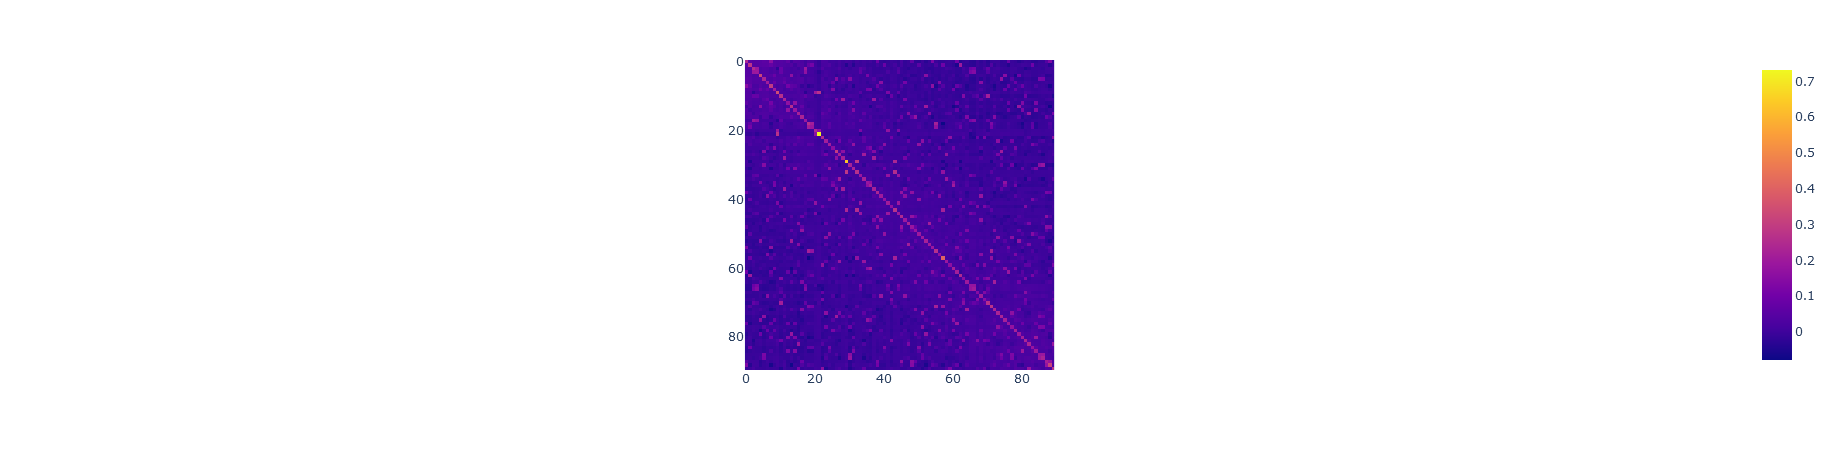

In [18]:
px.imshow(M2.calc_hat_matrix())


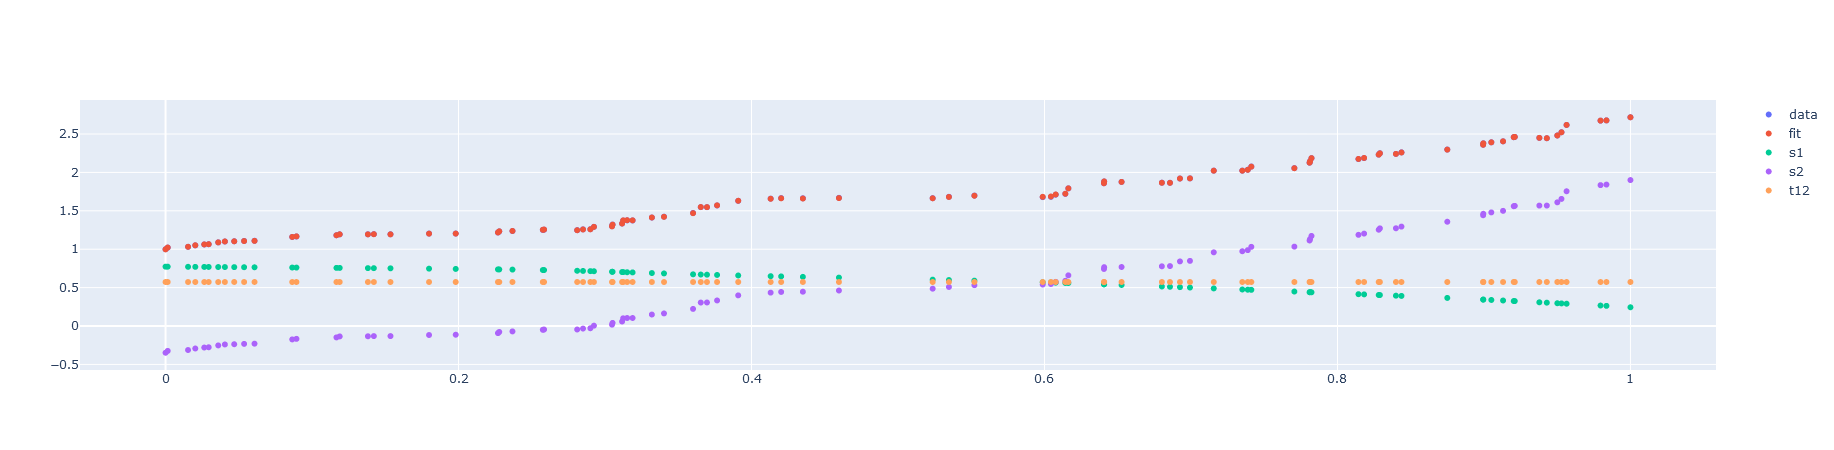

In [20]:
d = {"x":Xtrain[:,0], "y":ytrain, "yp": M2.basis @ M2.coef_, "yp_1":M2.smooths["s(1)"].basis @ M2.smooths["s(1)"].coef_, "yp_2":M2.smooths["s(2)"].basis @ M2.smooths["s(2)"].coef_,
     "yp_3":M2.smooths["t(1,2)"].basis @ M2.smooths["t(1,2)"].coef_}
df = pd.DataFrame(d)

fig = go.Figure()
fig.add_trace(go.Scatter(x=d["x"], y=ytrain, mode="markers", name="data"))
fig.add_trace(go.Scatter(x=d["x"], y=d["yp"], mode="markers", name="fit"))
fig.add_trace(go.Scatter(x=d["x"], y=d["yp_1"], mode="markers", name="s1"))
fig.add_trace(go.Scatter(x=d["x"], y=d["yp_2"], mode="markers", name="s2"))
fig.add_trace(go.Scatter(x=d["x"], y=d["yp_3"], mode="markers", name="t12"))
# fig = M2.plot_confidence_intervals(fig=fig, X=Xtrain, y=ytrain)
fig.show()

In [52]:
class SM():
    
    def __init__(self, description):
        """Initialitation of the Model using the nested tuple 'description'. 

        Parameters
        ----------
        description: tuple
            Description of the model

            Note
            ----       
            Using the scheme for the description tuple:

            (type of smooth, type of constraint, number of knots, lambdas, knot_type), 
            
            e.g. description = 
            ( 
            
                ("s(1)", "smooth", 25, (1, 100), "equidistant"),

                ("s(2)", "inc", 25, (1, 100), "quantile"), 
                
                ("t(1,2)", "smooth", [5,5], (1, 100), "quantile"), 
            
            ).
                        
        """

        self.description_str = description
        self.description_dict = {
            t: {"constraint": p, "n_param": n, 
                "lam" : {"smoothness": l[0], "constraint": l[1]},
                "knot_type": k
               } 
            for t, p, n, l, k  in self.description_str}
        self.smooths_list = list(self.description_dict.keys())
        self.smooths = None
        self.coef_ = None
        
        
    def create_basis(self, X, y=None):
        smooths = dict()
        for k,v in self.description_dict.items():
            if k.startswith("s"):
                smooths[k] = s(x_data=X[:,int(k[2])-1],  n_param=v["n_param"], constraint=v["constraint"], 
                                y_peak_or_valley=y,lambdas=v["lam"], type_=v["knot_type"])
            elif k.startswith("t"):
                smooths[k] = tps(x_data=X[:, [int(k[2])-1, int(k[4])-1]],  n_param=list(v["n_param"]), 
                                constraint=v["constraint"], lambdas=v["lam"], type_=v["knot_type"])
        self.basis = np.concatenate([v.basis for v in smooths.values()], axis=1)
        smoothnes_penalty_list = [v.lam["smoothness"] * v.smoothness for v in smooths.values()]
        self.smoothness_penalty_matrix = block_diag(*smoothnes_penalty_list)
        n_coef_list = [0] + [np.product(smooth.n_param) for smooth in smooths.values()]
        self.coef_list = np.cumsum(n_coef_list)
        self.smooths = smooths
    
    def calc_LS_fit(self, X, y):

        fitting = lstsq(a=self.basis, b=y, rcond=None)
        beta_0 = fitting[0].ravel()
        self.coef_, self.LS_coef_ = beta_0, beta_0   

        for i, v in enumerate(self.smooths.values()):
            v.coef_ = self.coef_[self.coef_list[i]:self.coef_list[i+1]]
        return self
            
    def create_constraint_penalty_matrix(self, beta_test=None):
        
        cpl = []
        for v in self.smooths.values():
            b = v.coef_
            P = v.penalty_matrix
            V = check_constraint(beta=b, constraint=v.constraint, smooth_type=type(v))
            cpl.append(v.lam["constraint"] * (P.real.T @ V @ P.real))

        self.constraint_penalty_matrix = cpm = block_diag(*cpl)
            
    def create_df_for_beta(self, beta_init):
        
        col_name = [ f"b_{i}" for i in range(len(beta_init))]        
        df = pd.DataFrame(columns=col_name)
        d = dict(zip(col_name, beta_init))
        df = df.append(pd.Series(d), ignore_index=True)
        return df
            
    def fit(self, X, y, plot_=True, max_iter=5):
        """Calculate the PIRLS fit for data (X, y).

        Calculate the penalized iterative reweighted least squares (PIRLS) fit for
        the data (X, y). For further information, see Hofner B., 2012.
        
        Parameters
        ----------
        X : np.ndarray
            Data of size (n_samples, n_dimensions).
        y : array
            Target data of size (n_samples, ).
        max_iter : int
            Maximal number of iterations of PIRLS.
        plot_ : boolean
            Indicatior whether to plot the results.
        
        Returns 
        -------
        self : object
            Returns the fitted model.

        """
        #  TODO:
        #     [x] check constraint violation in the iterative fit
        #     [x] incorporate TPS in the iterative fit

        X, y = check_X_y(X, y.ravel())
        self = self.calc_LS_fit(X=X, y=y)
        df = self.create_df_for_beta(beta_init=self.coef_)
        
        for i in range(max_iter):
            self.create_constraint_penalty_matrix()
            DVD = self.constraint_penalty_matrix
            DD = self.smoothness_penalty_matrix
            BB, By = self.basis.T @ self.basis, self.basis.T @ y
            v_old = check_constraint_full_model(model=self)
            beta_new = (np.linalg.pinv(BB + DD + DVD) @ By).ravel()
            self.coef_ = beta_new                       
            v_new = check_constraint_full_model(model=self)
            df.loc[i+1] = self.coef_
            delta_v = np.sum(v_new - v_old)
            #  change the criteria to the following: 
            #  print("Differences at the following coefficients: ", np.argwhere(v_old != v_new))
            
            for i, v in enumerate(self.smooths.values()):
                v.coef_ = self.coef_[self.coef_list[i]:self.coef_list[i+1]]
            if delta_v == 0: 
                break

        self.df = df
        self.mse = np.round(mean_squared_error(y, self.basis @ self.coef_), 7)       

        return self
    
    def predict(self, X, extrapol_type="zero", depth=10):

        y_pred = []
        for x in X:
            if np.all(x >= 0) and np.all(x <= 1):
                pred = []
                for k, v in sm.smooths.items():
                    if k.startswith("s"):
                        pred.append(v.spp(sp=x[int(k[2])-1], coef_=v.coef_))
                    elif k.startswith("t"):
                        pred.append(v.spp(sp=x[int(k[2])-1:int(k[4])], coef_=v.coef_))
            else:
                pred.append(self.extrapolate(X=x, type_=extrapol_type, depth=depth))
            y_pred.append(sum(pred))
        y_pred = np.array([y_pred])
        return y_pred.ravel()

In [45]:
for k, v in sm.smooths.items():
    if k.startswith("s"):
        print(k, "\t", v.spp(sp=Xtest[0, int(k[2])-1], coef_=v.coef_))
    elif k.startswith("t"):
        print(k, "\t", v.spp(sp=Xtest[0, int(k[2])-1:int(k[4])], coef_=v.coef_))
        

s(1) 	 1.5945791351411547
s(2) 	 2.111644927272948
t(1,2) 	 0.8060673489629775


In [44]:
for k, v in sm.smooths.items():
    if k.startswith("t"):
        print(k, Xtest[0, int(k[2])-1:int(k[4])] ) #Xtest[0, int(k[2])-1:int(k[4])])

t(1,2) [0.97632641 0.96272012]


In [35]:
Xtest[0, int("t(1,2)"[2])-1 : int("t(1,2)"[4])]

array([0.97632641, 0.96272012])

In [32]:
int("t(1,2)"[2])-1

0

In [34]:
int("t(1,2)"[4])

2

In [53]:
sm = SM(description=m)
sm.create_basis(X=X, y=y)
sm.calc_LS_fit(X=X, y=y)
sm.create_constraint_penalty_matrix()
sm.fit(X=X, y=y)
#sm.create_df_for_beta(beta_init=sm.coef_)

In [54]:
sm.predict(Xtest)

array([4.51229141, 1.14560267, 2.23273876, 2.16234088, 1.67533673,
       1.20271154, 1.60215335, 2.58018635, 1.14937917, 2.1871473 ])

In [55]:
ytest

array([4.51195262, 1.1464727 , 2.23244618, 2.16645327, 1.67462963,
       1.2039354 , 1.60203411, 2.57571491, 1.15292918, 2.19444716])

In [56]:
mean_squared_error(sm.predict(Xtest), ytest)

1.0576550377305822e-05

### Rework **test_model_against_constraints**

In [6]:

def test_against_constraint(constraint, y_pred):

    if constraint == "inc":
        test = np.diff(y_pred) < 0
    elif constraint == "dec":
        test = np.diff(y_pred) > 0
    elif constraint == "conv":
        test = np.diff(np.diff(y_pred)) < 0
    elif constraint == "conc":
        test = np.diff(np.diff(y_pred)) > 0
    elif constraint == "peak":
        test = check_peak_constraint(beta=y_pred)
    elif constraint == "multi-peak":
        test = check_multi_peak_constraint(beta=y_pred)
    elif constraint == "valley":
        test = check_valley_constraint(beta=y_pred)
    elif constraint == "multi-valley":
        test = check_multi_valley_constraint(beta=y_pred)
    elif constraint == "peak-and-valley":
        test = check_peak_and_valley_constraint(beta=y_pred)
    return test


In [8]:
alltests = []
for k,v in M2.smooths.items():
    y_pred = v.basis @ v.coef_
    t = test_against_constraint(constraint=v.constraint, y_pred=y_pred)
    alltests.append(t)
    print(k, " ", v.constraint, " ", sum(t) / len(t))
    

s(1)   dec   0.4606741573033708
s(2)   inc   0.4606741573033708
t(1,2)   inc   0.6853932584269663


In [10]:
alltests = [item for sublist in alltests for item in sublist]

sum(alltests) / len(alltests)


0.5355805243445693